# Week 8 - Semantic Networks - Bayesian Echo Chamber

This week, we explore the representation and analysis of semantic networks. A word or document network is an unsupervized representation of text akin to a clustering or an embedding, but semantic networks can also be defined using semantic or syntactic information derived from methods we have used earlier in the quarter. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify *them*). Rendering words linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, andsophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity.

For this notebook we will use the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas as pd#For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #MAkes the plots look nice

import pickle #if you want to save layouts
import os

%matplotlib inline

We will primarily be dealing with graphs in this notebook, so lets first go over how to use them.

To start with lets create an undirected graph:

In [2]:
g = nx.Graph()
g

We can add nodes. These are all named, like entries in a dict.

In [3]:
g.add_node(1)
g.add_node(2)
g.add_node(3)

Now we have 3 vertices:

In [4]:
len(g.nodes)

3

Or if we want to get more information about the graph:

In [5]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 0
Average degree:   0.0000


We can give nodes properties, like name or type

In [6]:
g.nodes[1]

{}

In [7]:
g.nodes[1]['type'] = 'NN'

In [8]:
g.nodes[1]

{'type': 'NN'}

Still pretty boring though...

Lets add a couple of edges. Notice that we use the ids not any of the properties:

In [9]:
g.add_edges_from([(1, 2), (2, 3), (3, 1), (1,4)])
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4
Number of edges: 4
Average degree:   2.0000


Note how the summary has changed. Also there's one more node, since we asked for an edge to 4,

We can also give the edges properties like weights:

In [10]:
g.edges[1, 2]['weight'] = 2
g.edges[1, 4]['weight'] = 2
g.edges[1, 4]

{'weight': 2}

Let's visualize it now:

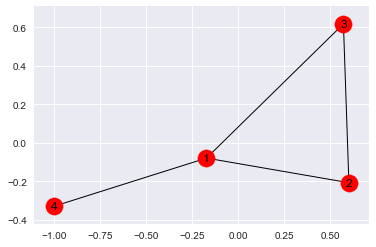

In [11]:
nx.draw_networkx(g)

Very exciting :-).

There are a great many things to do with the graph once we have created it, some of which we will explore today.

First lets load our data, the Grimmer corpus:

In [12]:
senReleasesDF = pandas.read_csv('../data/senReleasesTraining.csv', index_col = 0)
senReleasesDF[:3]

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We will be extracting sentences, as well as tokenizing and stemming. (You should be able to do this in your sleep now)

For now we will not be dropping any stop words:

In [13]:
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

Let's start by looking at words co-occurring in the same sentences:

In [14]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

Build a graph based on word cooccurence in the first 10 press releases.

In [17]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:10].sum())

Total number of vertices:

In [18]:
len(g.nodes)

1052

Total number of edges:

In [19]:
len(g.edges)

220119

A part of the adjacency matrix of cleaned word by press releases:

In [20]:
nx.to_numpy_matrix(g)[:5, :5]

matrix([[2., 0., 0., 4., 0.],
        [0., 0., 0., 0., 3.],
        [0., 0., 0., 0., 0.],
        [4., 0., 0., 2., 0.],
        [0., 3., 0., 0., 8.]])

We can save the graph and read it later, although this is slow if there are lots of edges or nodes, so we will filter first.

In [21]:
#nx.write_graphml(g, '../data/Obama_words.graphml')

Or, we can build graphs starting with a two-mode network. Let's again use the document-word frequency matrix that we used in week 3.

In [22]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [190]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(senReleasesDF['text'][:100])

In [191]:
senVects_incidence.shape

(100, 4270)

We need to turn the incidence matrix into a network. Note the use of bipartite as an attribute, you need to use it to tell networkx the graph is bipartite.

In [192]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [193]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 4370
Number of edges: 22325
Average degree:  10.2174


A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm (or spring layout), which uses a physical metaphor for lay-out. Nodes repel one another, and edges draw connected elements together like springs. The algorithm attempts to minimize the energy in such a system. For a large graph, however, the algorithm is computational demanding. The commented code gives you a layout and you can save it as a pickle. Let's then load a layout.

In [194]:
#These take a long time
#layout = nx.spring_layout(g_2mode)
#pickle.dump(layout, open( "layout.pkl", "wb" ) )
#layout = pickle.load(open('layout.pkl','rb'))

Then, let's plot the bipartite network with a quick spring layout:

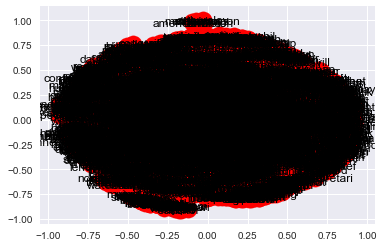

In [195]:
nx.draw_networkx(g_2mode)

A bit silly, but if we want even faster computation and tunable visualizations, check out [Pajek](http://mrvar.fdv.uni-lj.si/pajek/) or [gephi](https://gephi.org/).

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share.

In [196]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [197]:
gDoc = contractNetwork(g_2mode, 'doc')

Let's first take a look at the document-to-document network:

In [198]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4950
Average degree:  99.0000


Let's do a visualization. It is not surprising that almost every document is connected to every one else. We can use edge weight to distinguish distance (modeled as attraction) between the nodes.

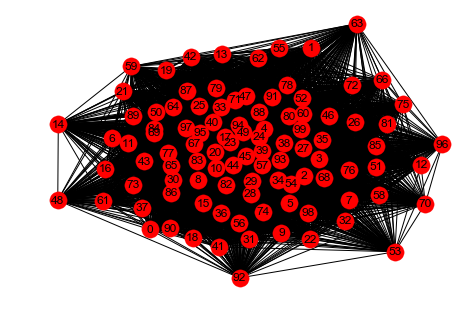

In [199]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

Lets deaw the graph with high and low weight edges distinguished:

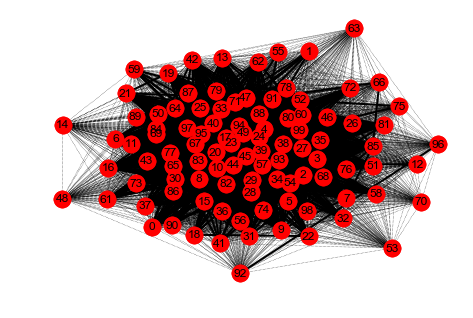

In [200]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 53 and 63 are on the outside and even look at them:

In [205]:
print(senReleasesDF.iloc[63]['text'].strip().replace('  ', '\n'))

FOR IMMEDIATE RELEASE

Senator Kennedy issued the following statement this evening following Senator Kerrys apology

John Kerry s statement says it all
I wish the Bush administration brought as much energy and focus to trying to correct their mistakes in Iraq as it did in going after John Kerry


Now let's turn it around and look at the word-to-word network (via documents). 

In [206]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 4270
Number of edges: 2080405
Average degree: 974.4286


First, let's reduce the number of words to a manageable size.

In [208]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.9883402510568855

Lets drop all the edges with weight below 5, then drop all the isolates

In [212]:
gWord.remove_edges_from([(n1, n2) for n1, n2, d in gWord.edges(data = True) if d['weight'] <= 5])
gWord.remove_nodes_from(list(nx.isolates(gWord))) #since we are changing the graph list() evuluates the isolates first
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 1028
Number of edges: 110902
Average degree: 215.7626


A bit smaller now, Now, let's visualize it: 

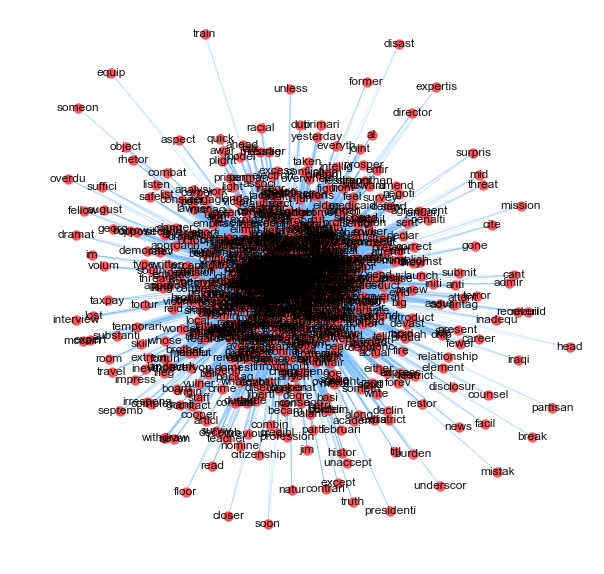

In [213]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

Still a bit messy, lets remove a few more edges

In [229]:
minWeight = 20
gWord.remove_edges_from([(n1, n2) for n1, n2, d in gWord.edges(data = True) if d['weight'] <= minWeight])
gWord.remove_nodes_from(list(nx.isolates(gWord))) #since we are changing the graph list() evuluates the isolates first
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 221
Number of edges: 3636
Average degree:  32.9050


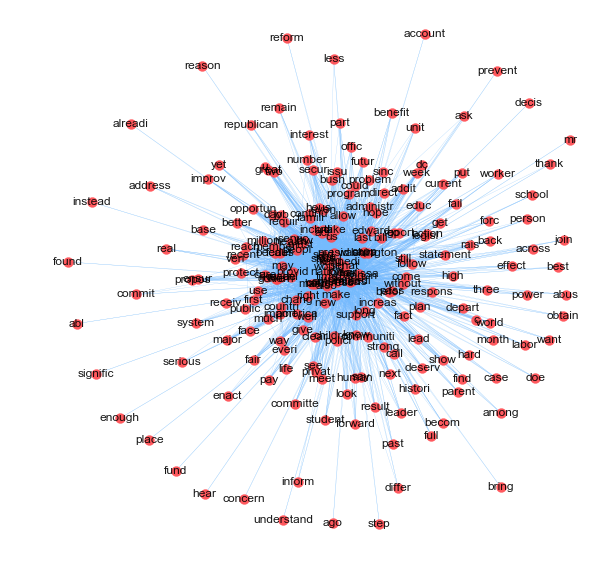

In [230]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can continue to trim globally or locally, to investigate the structure of words around a core word of interest.

## <span style="color:red">*Your Turn*</span>

<span style="color:red">Construct cells immediately below this that render some reasonable networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. Also create some smaller, word neighborhood graphs. What are useful filters and thresholds and what semantic structures do they reveal that given insight into the social world and social game inscribed in your corpus?

Alternatively, there are some more informative networks statistics.

Lets begin with measures of centrality. The concept of centrality is that some nodes (words or documents) are more *central* to the network than others. There are many distinct and opposing operationalizations of this concept, however. One important concept is *betweenness* centrality, which distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. 

In [231]:
centralities = nx.betweenness.betweenness_centrality(gWord)

In [232]:
centralities['senat']

0.04734352237607165

In [233]:
max(centralities.items(), key = lambda x : x[1])

('immedi', 0.19087876152463606)

We can color and size the nodes by betweenness centrality, it's much faster to redraw since we aren't redoing the layout.

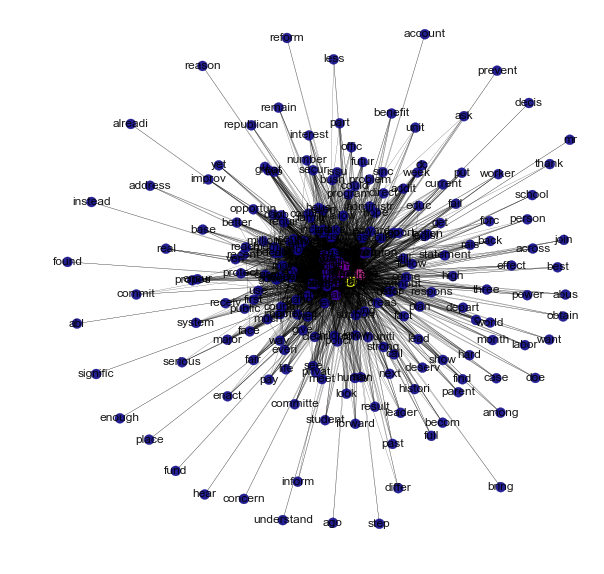

In [234]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [centralities[n] / maxC for n in gWord.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of betweenness centrality is:

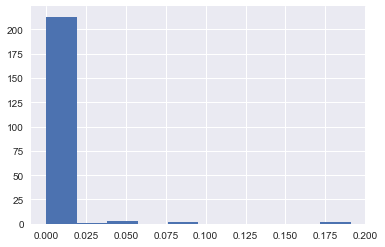

In [235]:
plt.hist(list(centralities.values()))
plt.show()

This is an exponential distrubution, you might need to add more nodes to see it though

Another way to visualize the graph involes the use of size to represent betweenness centrality and edge weight:

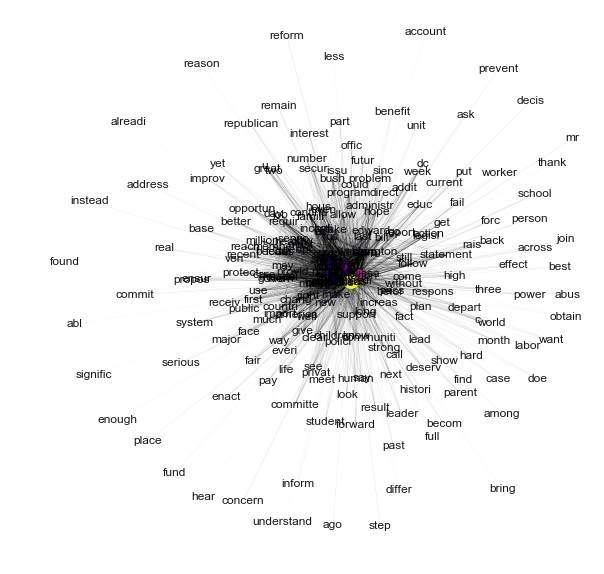

In [236]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gWord.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gWord.edges(data = True)))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in gWord.nodes],
        node_size = [centralities[n] / maxC * 200 for n in gWord.nodes],
        cmap = plt.get_cmap('plasma')) 

Here it appears that "health"/"drug", "torture"/"Iraq", and "loan"/"lend" are key concepts that connect others in the broader network. This is interesting in that they seem to be a domain-specific rather than linking words like "require" and "govern".

What are the top ten words in terms of betweenness?

In [237]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('immedi', 0.19087876152463606),
 ('releas', 0.19087876152463606),
 ('melissa', 0.08050654622091373),
 ('wagon', 0.08050654622091373),
 ('senat', 0.04734352237607165),
 ('today', 0.04157952229700311),
 ('year', 0.039121757516697865),
 ('need', 0.026397901516250374),
 ('make', 0.017762124455757367),
 ('work', 0.014156496046932676)]

What are words further down (the lowest all have centralities of 0):

In [243]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('live', 0.0001966863473196155),
 ('well', 0.0001415476162889018),
 ('hous', 0.00013226757391151953),
 ('even', 0.00011748532082348643),
 ('requir', 0.00011254339042789063),
 ('countri', 0.0001032672419359428),
 ('may', 8.730864755312303e-05),
 ('govern', 8.458931113147944e-05),
 ('allow', 6.590217695080208e-05),
 ('reach', 5.806347553718725e-05)]

Alternatively, we can look at degree centrality, which is simply the number of connections possessed by each node.

In [244]:
centralities = nx.degree_centrality(gWord)

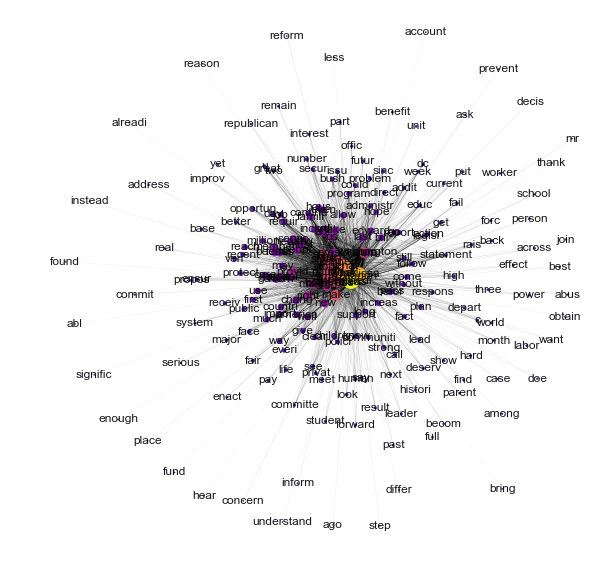

In [245]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gWord.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gWord.edges(data = True)))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in gWord.nodes],
        node_size = [centralities[n] / maxC * 200 for n in gWord.nodes],
        cmap = plt.get_cmap('plasma')) 

The top 10 words by degree are:

In [246]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('immedi', 1.0),
 ('releas', 1.0),
 ('melissa', 0.8681818181818182),
 ('wagon', 0.8681818181818182),
 ('senat', 0.7545454545454545),
 ('today', 0.7454545454545454),
 ('year', 0.7272727272727273),
 ('need', 0.6409090909090909),
 ('make', 0.5772727272727273),
 ('work', 0.5590909090909091)]

And the bottom 10:

In [247]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('hear', 0.00909090909090909),
 ('instead', 0.00909090909090909),
 ('mr', 0.00909090909090909),
 ('place', 0.00909090909090909),
 ('prevent', 0.00909090909090909),
 ('reason', 0.00909090909090909),
 ('reform', 0.00909090909090909),
 ('signific', 0.00909090909090909),
 ('step', 0.00909090909090909),
 ('understand', 0.00909090909090909)]

The distrubtioon of degree looks like

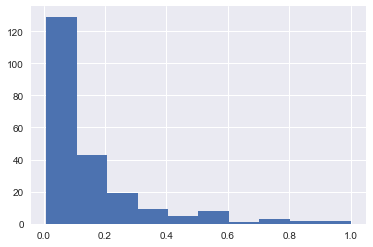

In [249]:
plt.hist(list(centralities.values()))
plt.show()

We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [250]:
centralities = nx.closeness_centrality(gWord)

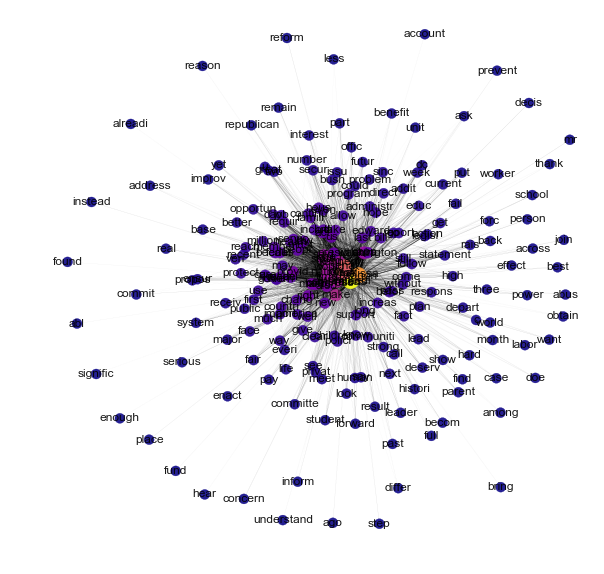

In [251]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gWord.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gWord.edges(data = True)))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in gWord.nodes],
        node_size = [centralities[n] / maxC * 200 for n in gWord.nodes],
        cmap = plt.get_cmap('plasma')) 

Top and bottom:

In [252]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('immedi', 1.0),
 ('releas', 1.0),
 ('melissa', 0.8835341365461847),
 ('wagon', 0.8835341365461847),
 ('senat', 0.8029197080291971),
 ('today', 0.7971014492753623),
 ('year', 0.7857142857142857),
 ('need', 0.7357859531772575),
 ('make', 0.7028753993610224),
 ('work', 0.694006309148265)]

In [253]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('hear', 0.502283105022831),
 ('instead', 0.502283105022831),
 ('mr', 0.502283105022831),
 ('place', 0.502283105022831),
 ('prevent', 0.502283105022831),
 ('reason', 0.502283105022831),
 ('reform', 0.502283105022831),
 ('signific', 0.502283105022831),
 ('step', 0.502283105022831),
 ('understand', 0.502283105022831)]

Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [254]:
centralities = nx.eigenvector_centrality(gWord)

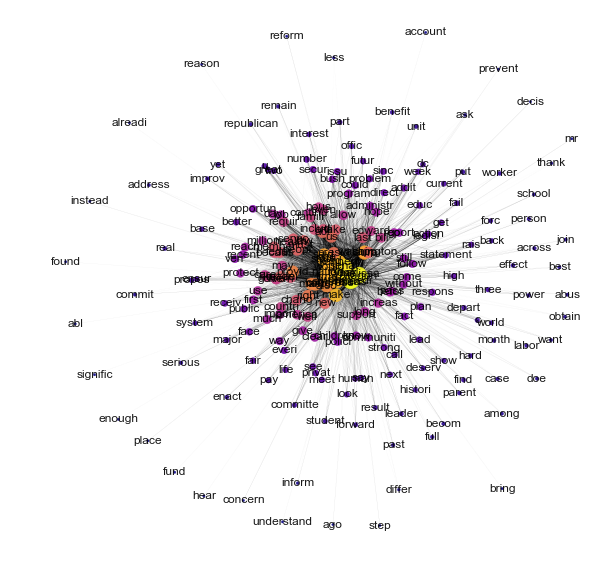

In [255]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gWord.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gWord.edges(data = True)))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in gWord.nodes],
        node_size = [centralities[n] / maxC * 200 for n in gWord.nodes],
        cmap = plt.get_cmap('plasma')) 

Top and bottom:

In [256]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('releas', 0.1680550432266714),
 ('immedi', 0.16805504322667136),
 ('melissa', 0.16532566182061936),
 ('wagon', 0.16532566182061936),
 ('today', 0.15967622471868856),
 ('senat', 0.1594407531110345),
 ('year', 0.1583828812744984),
 ('need', 0.1509261538822191),
 ('make', 0.14556595481284718),
 ('nation', 0.14383899756973098)]

In [257]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('hear', 0.005074285342224491),
 ('instead', 0.005074285342224491),
 ('mr', 0.005074285342224491),
 ('place', 0.005074285342224491),
 ('prevent', 0.005074285342224491),
 ('reason', 0.005074285342224491),
 ('reform', 0.005074285342224491),
 ('signific', 0.005074285342224491),
 ('step', 0.005074285342224491),
 ('understand', 0.005074285342224491)]

## <span style="color:red">*Your Turn*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents?

We can also look at global statistics, like the density of a network, defined as the number of edges existing divided by the total number of edges possible:

In [258]:
nx.density(gWord)

0.1495680789798437

We can also calculate the average degree per node:

In [266]:
np.mean([v for w,v in nx.degree(gWord)])

32.90497737556561

The diameter calculates the average distance between any two nodes in the network:

In [267]:
nx.diameter(gWord)

2

Moreover, we can find cliques, or completely connected sets of nodes:

In [270]:
nx.clique.number_of_cliques(gWord)['presid']

206

In [275]:
print(', '.join(max(nx.clique.find_cliques(gWord), key = lambda x: len(x))))

immedi, releas, melissa, wagon, senat, today, year, need, make, american, nation, state, would, time, work, kennedi, said, one, laura, capp, congress, also, provid, help, mani, ani, member, act, peopl, right, new, includ, servic, law, washington, feder


Now lets look at a subgraph of the network, those nodes that are within 2 edges 'american'.

In [279]:
americanNeighbors = gWord.neighbors('american')
americanNeighborsPlus1 = set(americanNeighbors)
for n in americanNeighbors:
    americanNeighborsPlus1 |= set(gWord.neighbors(n))

In [282]:
G_american = gWord.subgraph(americanNeighborsPlus1)
print(nx.info(G_american))

Name: 
Type: SubGraph
Number of nodes: 120
Number of edges: 2773
Average degree:  46.2167


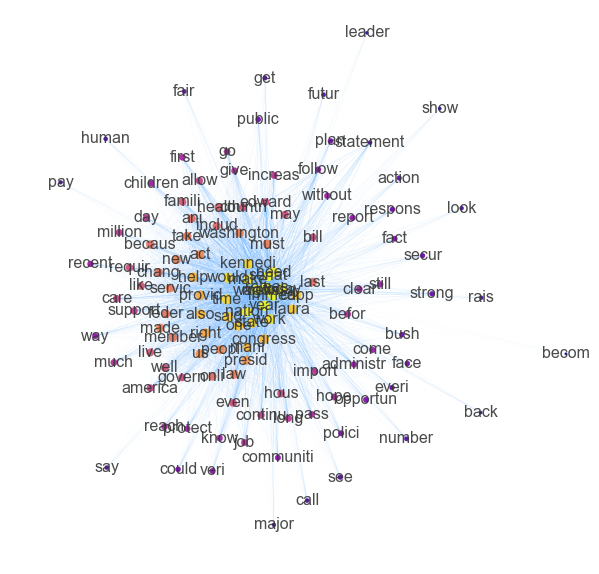

In [349]:
layout_amer = nx.spring_layout(G_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(G_american)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in G_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in G_american.edges(data = True)))
nx.draw(G_american, ax = ax, pos = layout_amer, labels = {n:n for n in G_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in G_american.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_amer[n] / maxC for n in G_american.nodes],
        node_size = [centralities_amer[n] / maxC * 100 for n in G_american.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

# POS based networks

Now lets look at links between specific parts of speech within a network.

For this we will be using the `nltk` POS facilities instead of the Stanford ones. These are much faster, but also somewhat less accurate. (You get what you *pay* for in computational power).

Lets look at nouns co-occurring in sentences using the top 10 (by score) reddit posts:

In [300]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col = 0)

In [304]:
redditTopScores = redditDF.sort_values('score')[-100:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[:3]

,author,over_18,score,subreddit,text,title,url,sentences
99,jimmy_three_shoes,False,4990,Tales From Tech Support,"This happened a little while ago, when I was c...","We've tried nothing, and we're all out of ideas!",https://www.reddit.com/r/talesfromtechsupport/...,"[[This, happened, a, little, while, ago, ,, wh..."
98,badbfriend,False,5034,Relationships,https://www.reddit.com/r/relationships/comment...,"Me [29 M] with my g/f [27 F] together 4 years,...",https://www.reddit.com/r/relationships/comment...,"[[https, :, //www.reddit.com/r/relationships/c..."
97,Fafrdr,False,5146,Relationships,First post: https://www.reddit.com/r/relations...,Update - My [16F] father [59M] acts creepy tow...,https://www.reddit.com/r/relationships/comment...,"[[First, post, :, https, :, //www.reddit.com/r..."


Now we'll normalize the tokens through stemming:

In [309]:
redditTopScores['normalized_sents'] = redditTopScores['sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

In [316]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [352]:
gNN = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN')

In [353]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 2628
Number of edges: 26120
Average degree:  19.8782


This is a bit to large to effectively visilize, so let's remove the verices whose degree is less than or equal to 100:

In [354]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 100]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 87
Number of edges: 1922
Average degree:  44.1839


And low weight edges:

In [355]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 87
Number of edges: 486
Average degree:  11.1724


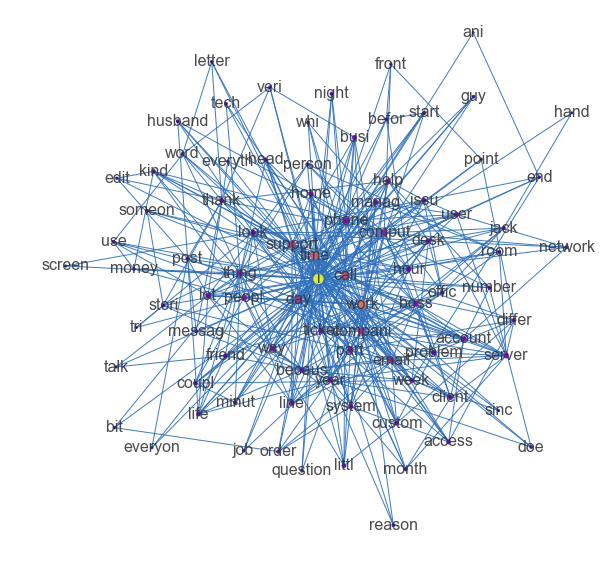

In [356]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

That is an interesting pattern, everyone is talking about themselves ("I...this", "I...that").

What if we want to look at noun-verb pairs instead?

In [357]:
gNV = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN', 'VB')

`gNV` has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:

In [358]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2868
Number of edges: 40458
Average degree:  28.2134


In [364]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [365]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2868
Number of edges: 13327
Average degree:   9.2936


Dropping low weight edges and low degree vertices again gives us:

In [368]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [369]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 83
Number of edges: 451
Average degree:  10.8675


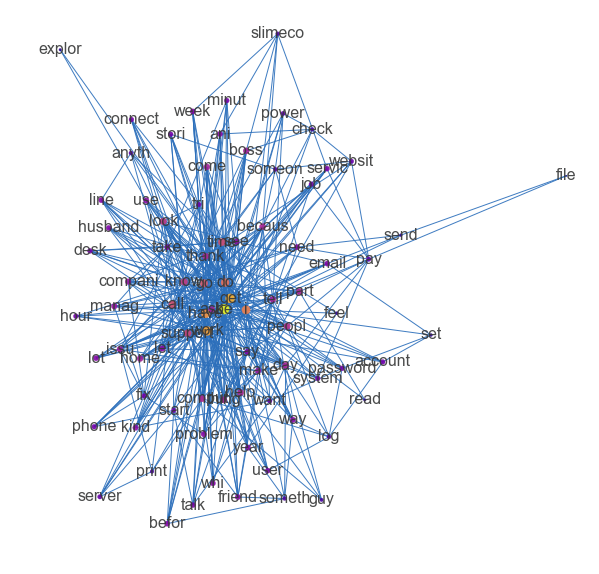

In [371]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

Lets create an "ego network" surrounding a single (important) word, like we did before:

In [374]:
g_i = gNV.subgraph(['i'] + list(gNV.neighbors('i')))

In [375]:
print(nx.info(g_i))

Name: 
Type: SubGraph
Number of nodes: 34
Number of edges: 33
Average degree:   1.9412


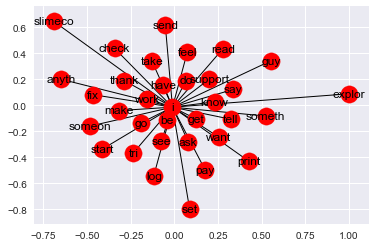

In [378]:
nx.draw_networkx(g_i)

Instead of just those connect to a vertex we can find all those connected to it within 2 hops, lets look at 'stori' for this

In [379]:
g_stori = gNV.subgraph(['stori'] + list())

In [ ]:
gNV.vs.find('stori')

In [390]:
storyNeighbors = gNV.neighbors('stori')
set(storyNeighbors)

{'be', 'get', 'know', 'someon', 'support', 'thank', 'tri'}

In [394]:
storyNeighbors = set(gNV.neighbors('stori'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [395]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: SubGraph
Number of nodes: 56
Number of edges: 161
Average degree:   5.7500


A largis network, but we can compute some statistics:

In [397]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('be', 0.8727272727272727),
 ('get', 0.7090909090909091),
 ('support', 0.39999999999999997),
 ('know', 0.36363636363636365),
 ('thank', 0.3090909090909091),
 ('tri', 0.14545454545454545),
 ('stori', 0.12727272727272726),
 ('i', 0.12727272727272726),
 ('call', 0.12727272727272726),
 ('someon', 0.12727272727272726)]

Or by eignvector centrality:

In [398]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('be', 0.43928984202898547),
 ('get', 0.3826631410829018),
 ('support', 0.24421847103891106),
 ('know', 0.21111457825779448),
 ('thank', 0.19442994690119694),
 ('stori', 0.15627933587529896),
 ('i', 0.15627933587529896),
 ('call', 0.15627933587529896),
 ('issu', 0.148255321393808),
 ('help', 0.148255321393808)]

Notice that 'stori' isn't even in the top 5:

Lets plot it

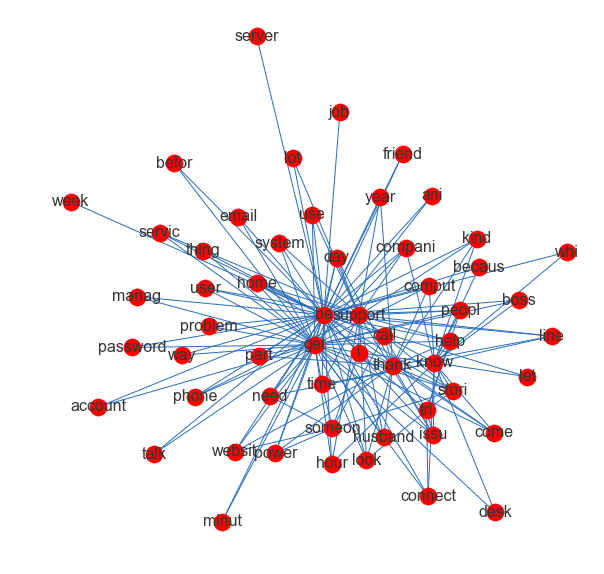

In [400]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

I is still in the middle

## <span style="color:red">*Your Turn*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, that illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful?